In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
import spacy
import regex as re
import unicodedata
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

# Carregando os dados

In [3]:
hs_df = pd.read_csv('https://raw.githubusercontent.com/UFRJ-Analytica/raspagem-de-dados-publicos/main/analise_de_tweets_com_python/hs.csv')
hs_df.head()

,text,homophobia,obscene,insult,racism,misogyny,xenophobia
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0


In [4]:
aux = hs_df[['homophobia','obscene', 'insult', 'racism', 'misogyny','xenophobia']].apply(lambda x: np.where(x > 0, 1, x) , axis=1, result_type='expand')

hs_df[['homophobia','obscene', 'insult', 'racism', 'misogyny','xenophobia']] = aux

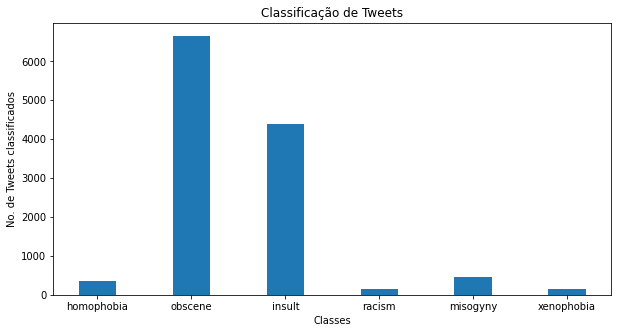

In [5]:
tweet_sum_df = hs_df[['homophobia','obscene', 'insult', 'racism', 'misogyny','xenophobia']].sum()

fig = plt.figure(figsize = (10, 5))

plt.bar(x=tweet_sum_df.index, height=tweet_sum_df.values, width = 0.4)
 
plt.xlabel("Classes")
plt.ylabel("No. de Tweets classificados")
plt.title("Classificação de Tweets")
plt.show()

In [6]:
pol_tweets = pd.read_csv('https://raw.githubusercontent.com/UFRJ-Analytica/raspagem-de-dados-publicos/main/analise_de_tweets_com_python/tweets.csv').drop('Unnamed: 0', axis=1)
pol_tweets

,created_at,tweet,author,retweet,in_reply_to,coordinates
0,2021-11-11 22:21:52+00:00,RT @OGloboPolitica: Sonar: Novo vídeo do #Bols...,MarceloFreixo,False,NaN,NaN
1,2021-11-11 22:14:55+00:00,Gilberto Gil é imortal há muito tempo.,MarceloFreixo,False,NaN,NaN
2,2021-11-11 21:42:39+00:00,RT @arcelinobsilva: Você sabe o que é #Bolsoca...,MarceloFreixo,False,NaN,NaN
3,2021-11-11 21:28:39+00:00,@arcelinobsilva @felipeneto @alessandromolon @...,MarceloFreixo,False,arcelinobsilva,NaN
4,2021-11-11 21:28:26+00:00,RT @arcelinobsilva: Você já assistiu o vídeo q...,MarceloFreixo,False,NaN,NaN
...,...,...,...,...,...,...
26995,2021-04-18 00:50:04+00:00,Agradeço a todos que participaram do debate na...,cirogomes,False,NaN,NaN
26996,2021-04-18 00:45:54+00:00,Esse projeto deve ter um prazo objetivamente a...,cirogomes,False,cirogomes,NaN
26997,2021-04-18 00:45:54+00:00,O Brasil não vai sair dessa tragédia com mais ...,cirogomes,False,NaN,NaN
26998,2021-04-18 00:06:13+00:00,A política exterior brasileira precisa buscar ...,cirogomes,False,NaN,NaN


In [7]:
pol_tweets.author.unique()

array(['MarceloFreixo', 'jairbolsonaro', 'eduardopaes', 'CarlosBolsonaro',
       'BolsonaroSP', 'FlavioBolsonaro', 'CarlaZambelli38', 'Biakicis',
       'MottaTarcisio', 'LulaOficial', 'GuilhermeBoulos', 'gleisi',
       'mariadorosario', 'jandira_feghali', 'ManuelaDavila',
       'Haddad_Fernando', 'MarinaSilva', 'cirogomes'], dtype=object)

# Tratamento do texto, Lemmatização e Tokenização

In [8]:
!python -m spacy download pt_core_news_sm
!python -m spacy link pt_core_news_sm pt --force
nlp = spacy.load('pt')
tokenizer = TweetTokenizer()

nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('portuguese')
stopword_list[:10]

     |████████████████████████████████| 21.2 MB 5.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um']

In [9]:
tokenizer.tokenize(hs_df.text[20999])

['saudades',
 'da',
 'iasmin',
 'de',
 '2017',
 'eu',
 'era',
 'gótica',
 'demais',
 'pqp']

In [10]:
'''Remove stopwords'''
def remover_stop_words(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    return filtered_tokens

'''Remove acentos'''
def remover_acentos(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

'''Lematização
O objetivo da lematização é reduzir (deflexionar) uma palavra a sua base.

A lematização reduz a base utilizando um vocabulário e a análise morfológica das palavras.

Exemplos:
1. A palavra "walk" é a base para "walking", e é corretamente reduzida pelo stemming e pela lematização.
2. A palavra "better" tem "good" como base (ou lema). Esse link é perdido pelo stemming.
3. A palavra "meeting" pode ser reduzido para um substantivo ou um verbo dependendo do contexto. 
   E.g., "in our last meeting" ou "We are meeting again tomorrow". 
   A lematização consegue fazer a redução de forma correta.

Deve-se escolher um ou outro. A desvantagem da lematização é que ela é mais custosa do ponto de vista computacional.
'''
def lemmatize(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

'''Remove links'''
def strip_html_tags(text):
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"\s+", " ", text)
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [11]:
#Funções para limpar texto: chama todas as funções declaradas acima e faz mais alguns pré processamentos
def clean(doc):
    # remove links
    doc = strip_html_tags(doc)

    # coloca tudo em caixa baixa
    doc = doc.lower()

    # remove linhas em branco
    doc = re.sub(r'[\r|\n|\r\n|\s]+', ' ', doc)

    # lemmatização
    doc = lemmatize(doc)
    
    # remove acentuação
    doc = remover_acentos(doc)

    # remove stopwords
    doc = remover_stop_words(doc)
    
    return doc # retorna corpus pré processado

clean(hs_df.text[20999])

['saudade', 'iasmin', '2017', 'ser', 'gotico', 'demais', 'pqp']

# Feature Extraction

## Bag of Words

In [12]:
bow = CountVectorizer(tokenizer=clean) 
bow_fit = bow.fit_transform(hs_df.text)
bow.get_feature_names_out()

array(['!', '"', '#', ..., 'zzeeeeus', 'zzz', '~'], dtype=object)

In [13]:
bow_df = pd.DataFrame(bow_fit.toarray(), columns=bow.get_feature_names_out())
bow_df

,!,"""",#,#avantipalestra,#belaafeia,#esquemao,#fsradiobrasil,#mylove,#stfvergonhanacional,#stfvergonhanascional,#voleinaglobo,$,%,&,',(,(8,(:,),*,+,",",-,--->,.,. .,. ...,. .,. . .,. . . .,. . . . . . .,. . . . . . . . . .,. ..,. ...,..,.. ..,...,... .,... ...,/,...,zi,zica,zico,zicou,zidane,ziel,zika,zimbabue,zimbrar,ziplox,zjzkzkskskkzkjjxjs,zn,zoandoh,zoar,zodiaco,zoeira,zoeirinhas,zoi,zoia,zoiao,zoiuda,zombar,zombie,zonar,zoologico,zoom,zorra,zoto,zovo,zrg,zuando,zuar,zuavam,zulema,zulive,zumbir,zunir,zzeeeeus,zzz,~
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20996,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20998,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## tf-idf: Term Frequency - Inverse Document Frequency

In [14]:
tfidf = TfidfVectorizer(tokenizer=clean) 
tfidf_fit = tfidf.fit_transform(hs_df.text)
tfidf.get_feature_names_out()

array(['!', '"', '#', ..., 'zzeeeeus', 'zzz', '~'], dtype=object)

In [15]:
tfidf_df = pd.DataFrame(tfidf_fit.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df

,!,"""",#,#avantipalestra,#belaafeia,#esquemao,#fsradiobrasil,#mylove,#stfvergonhanacional,#stfvergonhanascional,#voleinaglobo,$,%,&,',(,(8,(:,),*,+,",",-,--->,.,. .,. ...,. .,. . .,. . . .,. . . . . . .,. . . . . . . . . .,. ..,. ...,..,.. ..,...,... .,... ...,/,...,zi,zica,zico,zicou,zidane,ziel,zika,zimbabue,zimbrar,ziplox,zjzkzkskskkzkjjxjs,zn,zoandoh,zoar,zodiaco,zoeira,zoeirinhas,zoi,zoia,zoiao,zoiuda,zombar,zombie,zonar,zoologico,zoom,zorra,zoto,zovo,zrg,zuando,zuar,zuavam,zulema,zulive,zumbir,zunir,zzeeeeus,zzz,~
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072345,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.112099,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078339,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.157846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20996,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102114,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20997,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.129238,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20998,0.0,0.0,0.532503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Aprendizado de Máquina

In [16]:
X = tfidf_df.values
y = hs_df[['homophobia', 'obscene', 'insult', 'racism', 'misogyny', 'xenophobia']]

## Árvores de Decisão

In [16]:
clf_tree = DecisionTreeClassifier(criterion="entropy")

scores_tree = cross_val_score(clf_tree, X, y['homophobia'], cv=5)
scores_tree

array([0.98666667, 0.98595238, 0.98714286, 0.98047619, 0.98404762])

In [17]:
clf_tree_dict = {}

for c in y.columns:
  clf_tree_dict[c] = clone(clf_tree).fit(X, y[c])

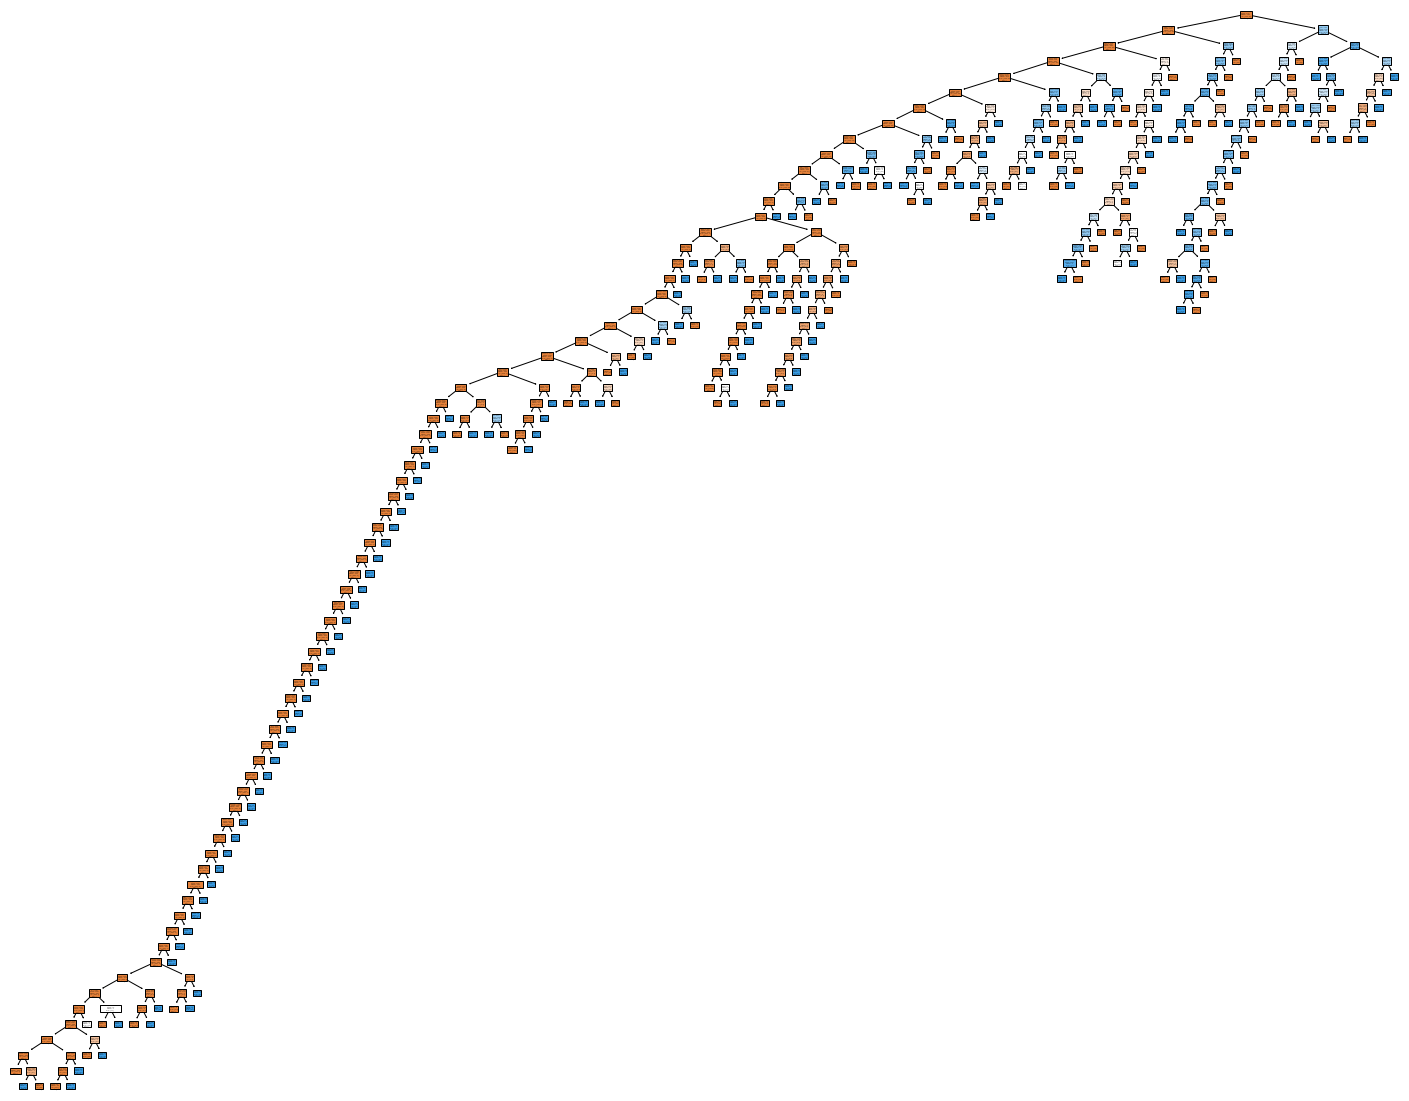

In [18]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(clf_tree_dict['homophobia'], feature_names=tfidf_df.columns, class_names=list(str(y.homophobia.unique())), filled=True)

## Florestas Aleatórias

In [17]:
clf_random_forest = RandomForestClassifier(n_estimators=100, bootstrap=True, max_features="sqrt", criterion="entropy")

scores_random_forest = cross_val_score(clf_random_forest, X, y['homophobia'], cv=5)
scores_random_forest

array([0.9852381 , 0.98428571, 0.98452381, 0.9847619 , 0.9847619 ])

In [18]:
clf_forest_dict = {}

for c in y.columns:
  clf_forest_dict[c] = clone(clf_random_forest).fit(X, y[c])

## Regressão Logística

In [19]:
clf_log = LogisticRegression(random_state=43, max_iter=1000)

scores_logistic = cross_val_score(clf_log, X, y['homophobia'], cv=5)
scores_logistic

array([0.98452381, 0.98452381, 0.9852381 , 0.98452381, 0.98380952])

In [20]:
clf_log_dict = {}

for c in y.columns:
  clf_log_dict[c] = clone(clf_log).fit(X, y[c])

# Realizando as predições

In [21]:
X_to_predict = tfidf.transform(pol_tweets.tweet)

In [22]:
for c in y.columns:
  pol_tweets[c] = clf_log_dict[c].predict(X_to_predict)

In [25]:
for c in y.columns:
  print(c+": "+str(np.sum(pol_tweets[c])))

homophobia: 0.0
obscene: 13.0
insult: 213.0
racism: 0.0
misogyny: 0.0
xenophobia: 0.0


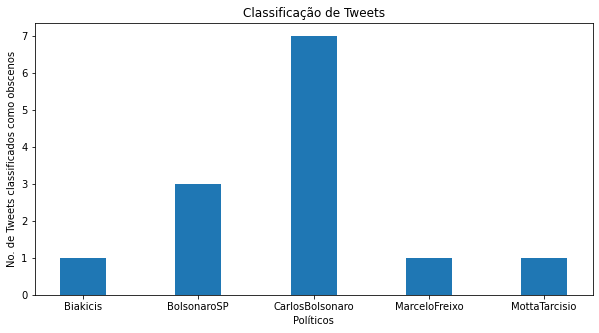

In [33]:
obscene_sum = pol_tweets.groupby(by=["author"]).sum()['obscene']
obscene_sum = obscene_sum[obscene_sum > 0]

fig = plt.figure(figsize = (10, 5))

plt.bar(x=obscene_sum.index, height=obscene_sum.values, width = 0.4)
 
plt.xlabel("Políticos")
plt.ylabel("No. de Tweets classificados como obscenos")
plt.title("Classificação de Tweets")
plt.show()

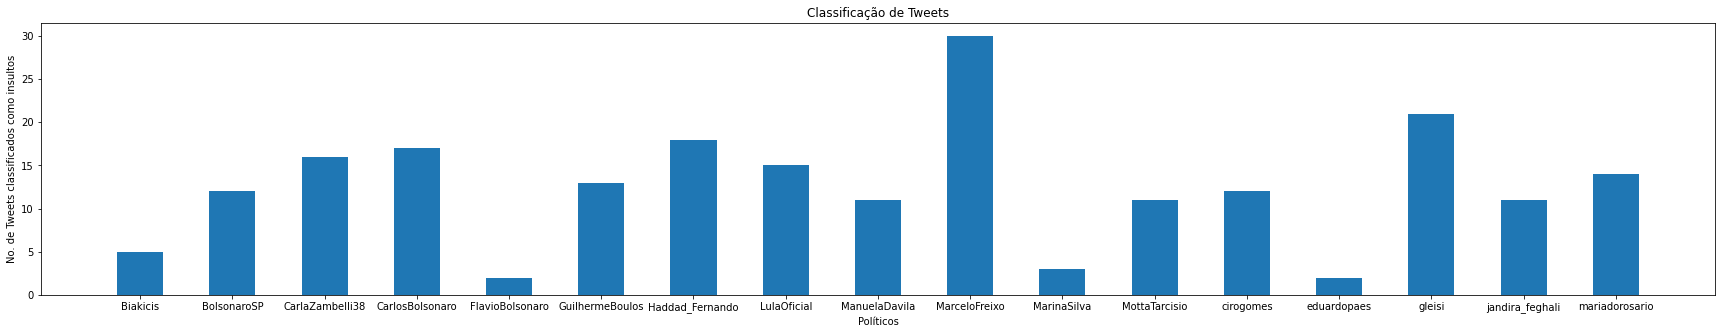

In [39]:
insult_sum = pol_tweets.groupby(by=["author"]).sum()['insult']
insult_sum = insult_sum[insult_sum > 0]

fig = plt.figure(figsize = (30, 5))

plt.bar(x=insult_sum.index, height=insult_sum.values, width = 0.5)
 
plt.xlabel("Políticos")
plt.ylabel("No. de Tweets classificados como insultos")
plt.title("Classificação de Tweets")
plt.show()